In [1]:
#import matplotlib
#matplotlib.u<se("TkAgg")

import sys
path = r"/Users/constantinslioussarenko/PythonGitRepositories/MyoMap"
#path = r"/home/cslioussarenko/PythonRepositories"
sys.path.append(path+"/epgpy")
sys.path.append(path+"/machines")
sys.path.append(path+"/mutools")
sys.path.append(path+"/dicomstack")
sys.path.append(path+"/mrf-sim")


from mrfsim import T1MRF
from image_series import *
from dictoptimizers import SimpleDictSearch
from utils_mrf import *
import seaborn as sns
from functools import reduce


import matplotlib.pyplot as plt
%matplotlib inline

def fill_dictfile_value_mapping(dictfile_list,FF_list = np.arange(0,1.05,0.05)):
    dictfile_value_mapping={}
    for dictfile in dictfile_list:
        keys,values=read_mrf_dict(dictfile,FF_list,aggregate_components=True)
        dictfile_value_mapping[dictfile]=values
    keys = np.array(keys)
    
    return dictfile_value_mapping,keys

def compare_dict_covariance(dictfile_value_mapping,keys,fixed_parameters_list):
    global param_index_mapping
    filtered_index_list=[]
    non_fixed_parameters_list=list(set(list(param_index_mapping.keys()))-set(list(fixed_parameters_list)))
    fixed_param_values_dict={}
    
    for p in fixed_parameters_list:
        index_fixed=param_index_mapping[p]
        p_fixed = np.random.choice(np.unique(keys[:,index_fixed]))
        fixed_param_values_dict[p]=p_fixed
        filtered_index_list.append((keys[:,index_fixed]==p_fixed))
    
    filtered_index_list=reduce(lambda x, y: x*y, filtered_index_list)
    index_filter = np.argwhere(filtered_index_list).flatten()
    keys_filtered = keys[index_filter]

    non_fixed_index_list=[]
    for p in non_fixed_parameters_list:
        non_fixed_index_list.append(param_index_mapping[p])   
    axis_values= np.round(keys_filtered[:,non_fixed_index_list],2)
    
    dictfile_corr_mapping={}
    
    for dict_file in dictfile_value_mapping.keys():
        signal = dictfile_value_mapping[dict_file][index_filter,:]
        cov_signal = np.real(signal@signal.conj().T)
        inverse_std_signal = np.diag(np.sqrt(1/np.diag(cov_signal)))
        corr_signal = inverse_std_signal@cov_signal@inverse_std_signal
        dictfile_corr_mapping[dict_file]=corr_signal
        
        plt.figure(figsize=(15,15))
        sns.heatmap(corr_signal,xticklabels=axis_values, yticklabels=axis_values)
        plt.title("{} :Fingerprints Correlation Map For {}".format(dict_file,fixed_param_values_dict))
        
    return dictfile_corr_mapping,axis_values

def compare_random_signals_correlations(dictfile_corr_mapping,axis_values,num_sig=1):
    corr_shape=list(dictfile_corr_mapping.values())[0].shape[0]
    for i in range(num_sig):
        num_signal=np.random.choice(corr_shape)
        plt.figure(figsize=(15,10))
        for dictfile in dictfile_corr_mapping.keys():
            corr_signal=dictfile_corr_mapping[dictfile]
            plt.plot(corr_signal[num_signal,:],label=dictfile)
        plt.axvline(x=num_signal,c="r")
        plt.title("Optim params : {}".format(axis_values[num_signal]))
        plt.legend()
    
def calculate_variance(index_param1,index_param2,index_param3,keys,values):
    param1_all=np.unique(keys[:,index_param1])
    param2_all=np.unique(keys[:,index_param2])
    param3_all=np.unique(keys[:,index_param3])

    variances=[]
    for p1 in tqdm(param1_all):
        for p2 in param2_all :
            for p3 in param3_all:
                index_keys = np.argwhere((keys[:,index_param1]==p1)&(keys[:,index_param2]==p2)&(keys[:,index_param3]==p3)).flatten()
                #print(index_keys)
                #print(keys[index_keys])
                if len(index_keys)==0:
                    continue
                    
                signal_filtered =values[index_keys,:]
                
                curr_std = np.std(signal_filtered,axis=0)
                variances.append(curr_std)

    variances=np.array(variances)
    mean_variance=np.mean(np.array(variances),axis=0)
    return mean_variance

Could not import cupy
Could not import SPIJN


In [2]:
param_index_mapping={
    "wT1":0,
    "B1":2,
    "Df":3,
    "FF":4
    
}

# Constant TE

In [76]:
#dictfile_list=["../mrf175_SimReco2_light.dict","../mrf175_SimReco2_light_constantTE_first.dict","../mrf175_SimReco2_light_constantTE_mid.dict","../mrf175_SimReco2_light_constantTE_last.dict"] 
dictfile_list=["../mrf60_SeqFF_light.dict","../mrf60_SeqFF_FA20_light.dict","../mrf60_SeqFF_FFonly_light.dict","../mrf60_SeqFF_FFDf_light.dict","../mrf60_SeqFF_optim_light.dict","../mrf60_SeqFF_Cohen_light.dict"]
dictfile_list=["../mrf60_SeqFF_light.dict","../mrf60_SeqFF_FFDf_light.dict","../mrf60_SeqFF_Cohen_light.dict","../mrf60_SeqFF_CohenWeighted_light.dict","../mrf78_SeqFF_CohenWeighted_light.dict"]
dictfile_list=["../mrf60_SeqFF_light.dict","../mrf60_SeqFF_FFDf_light.dict","../mrf60_SeqFF_Cohen_light.dict","../mrf60_SeqFF_CohenWeighted_light.dict","../mrf78_SeqFF_CohenWeighted_light.dict"]

dictfile_value_mapping,keys=fill_dictfile_value_mapping(dictfile_list)

## FF and Df

In [77]:
fixed_parameters_list=["wT1","B1"]


/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


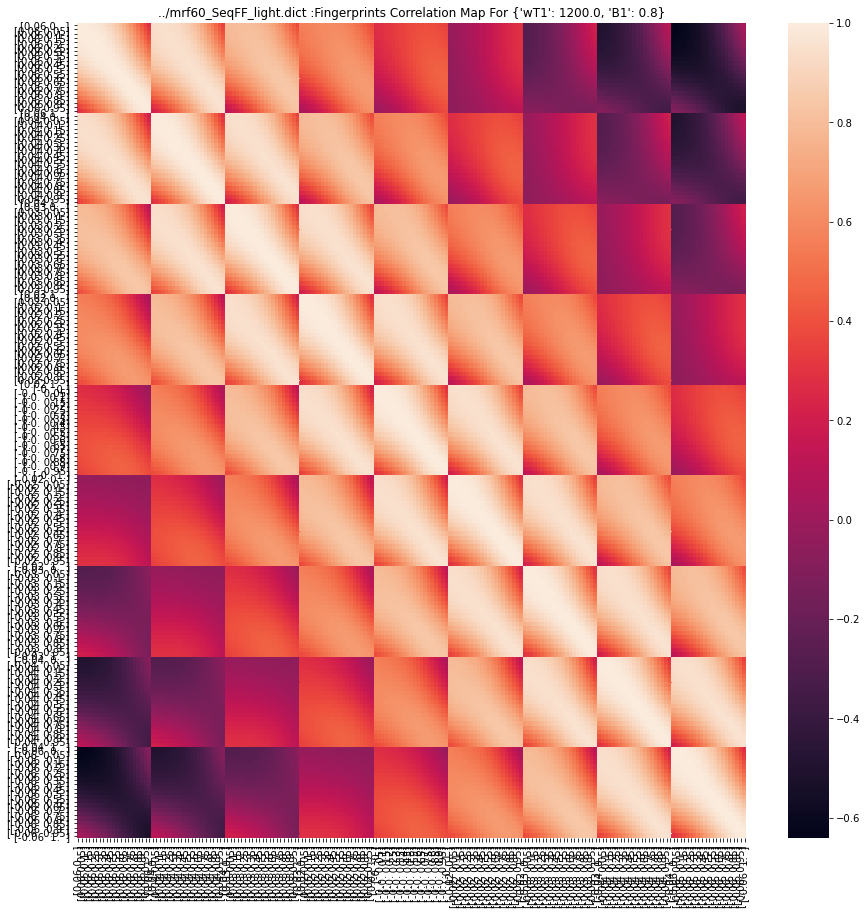

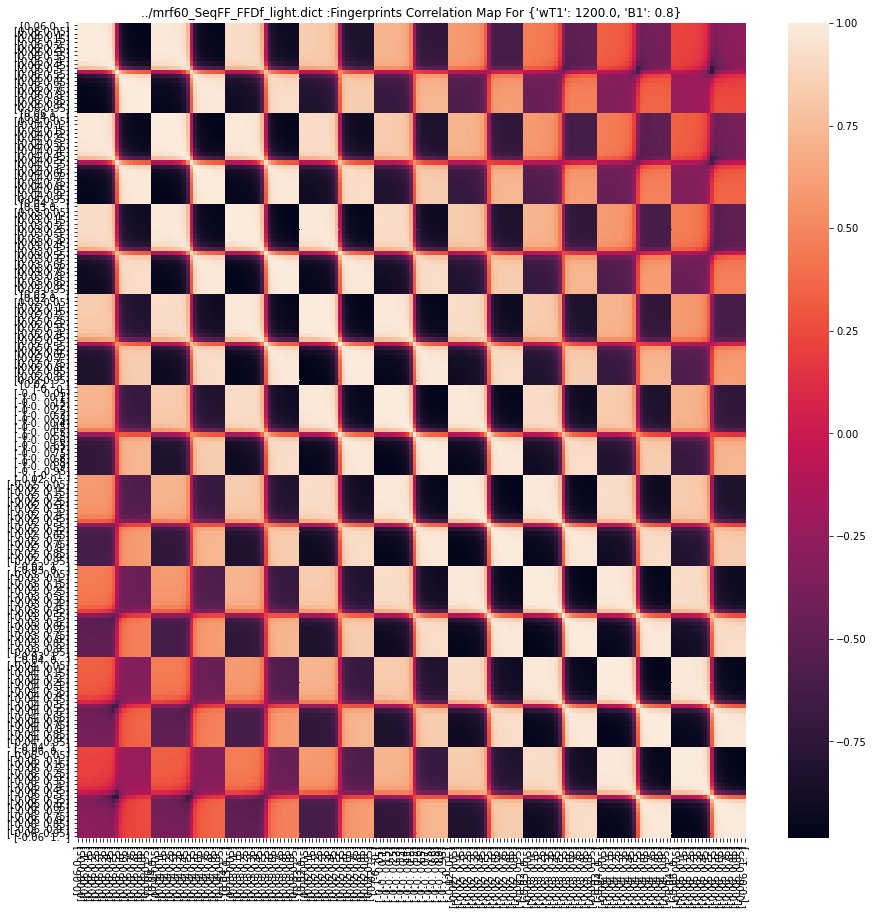

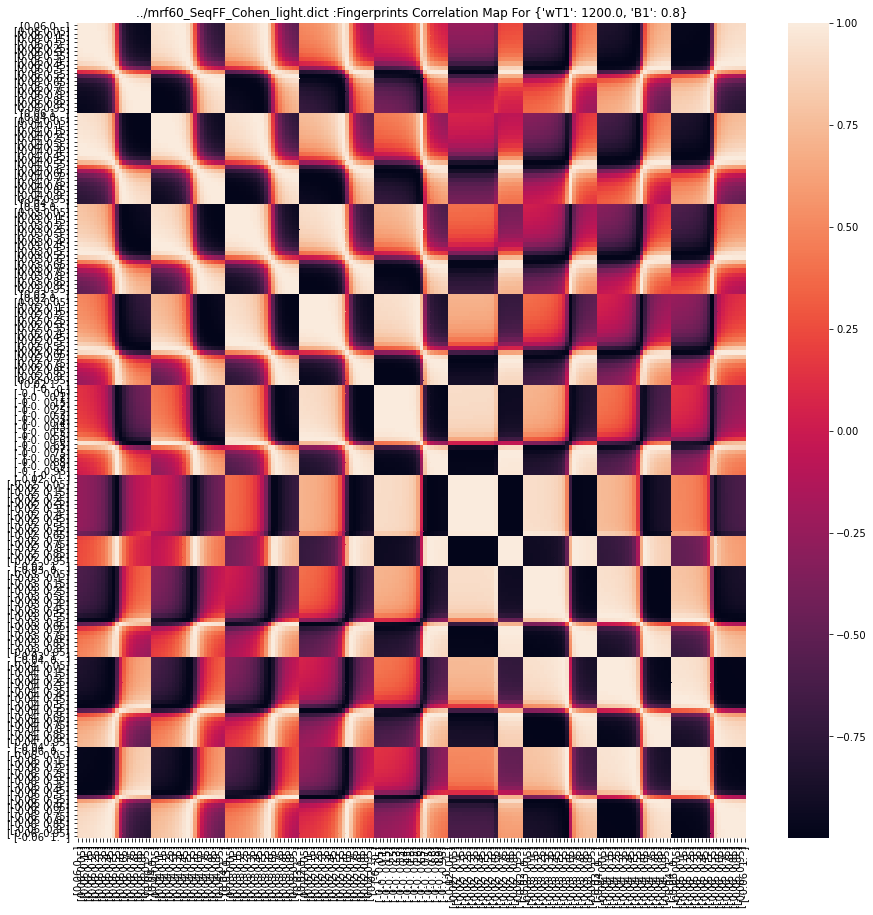

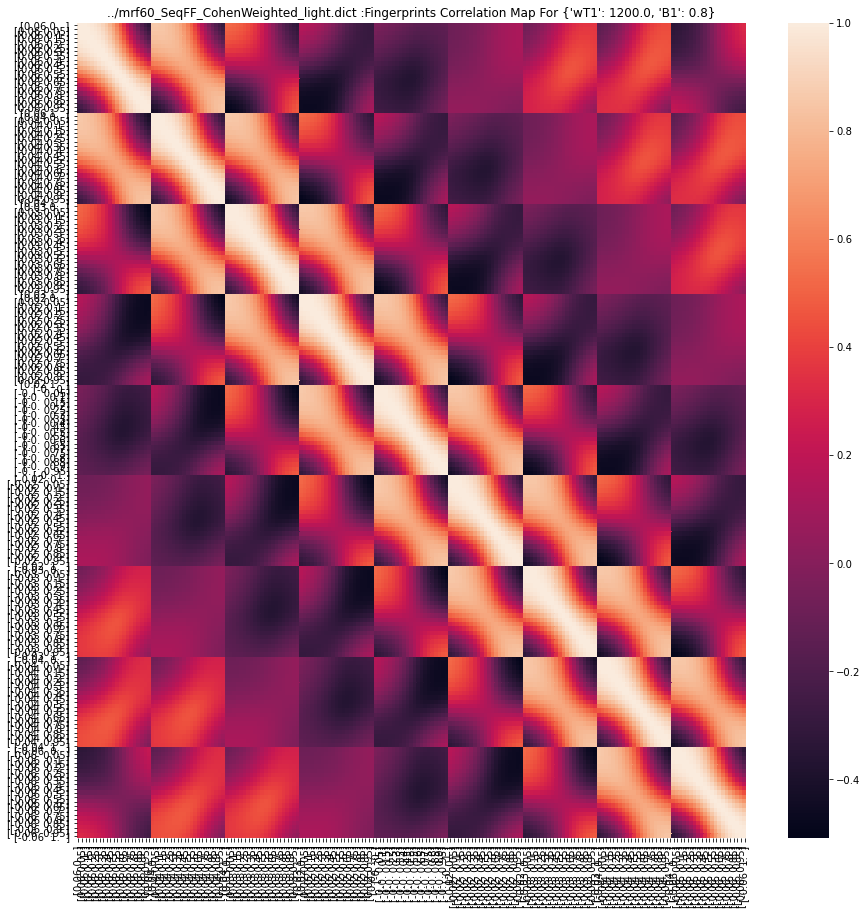

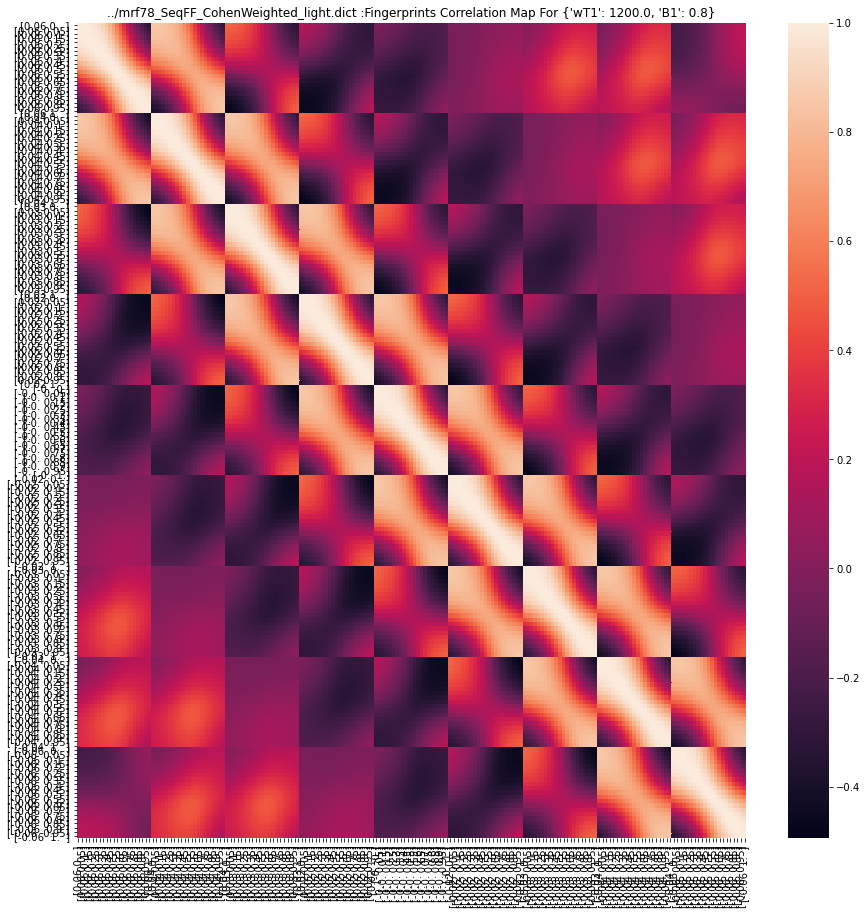

In [78]:
dictfile_corr_mapping,axis_values=compare_dict_covariance(dictfile_value_mapping,keys,fixed_parameters_list)

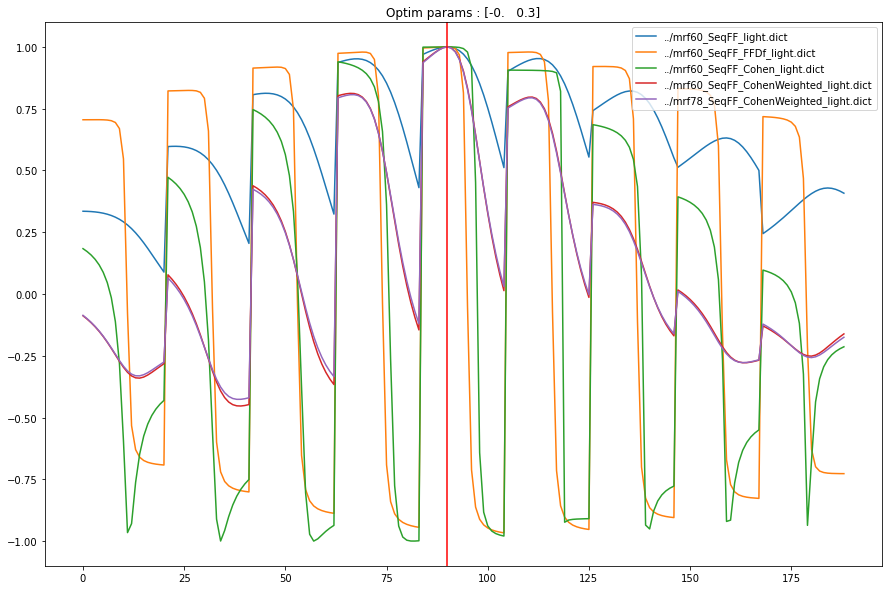

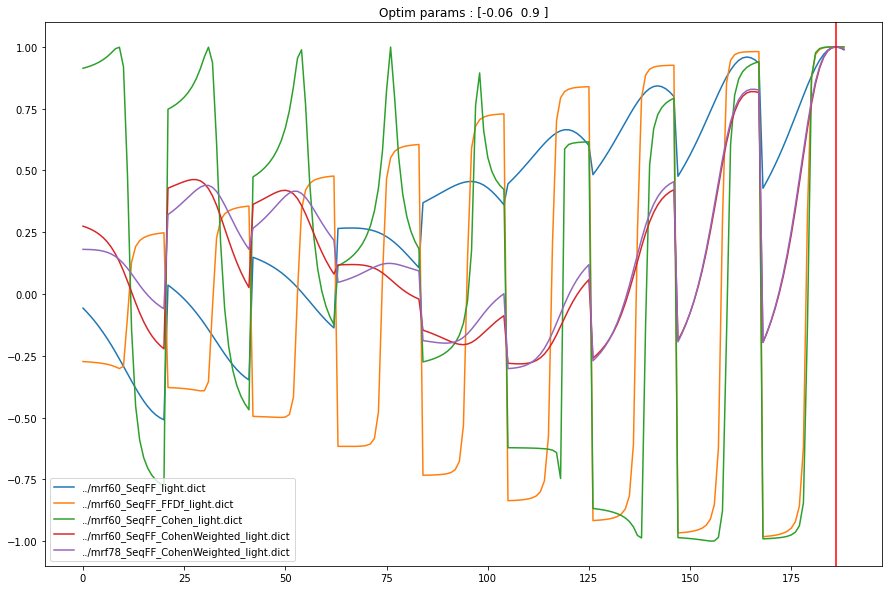

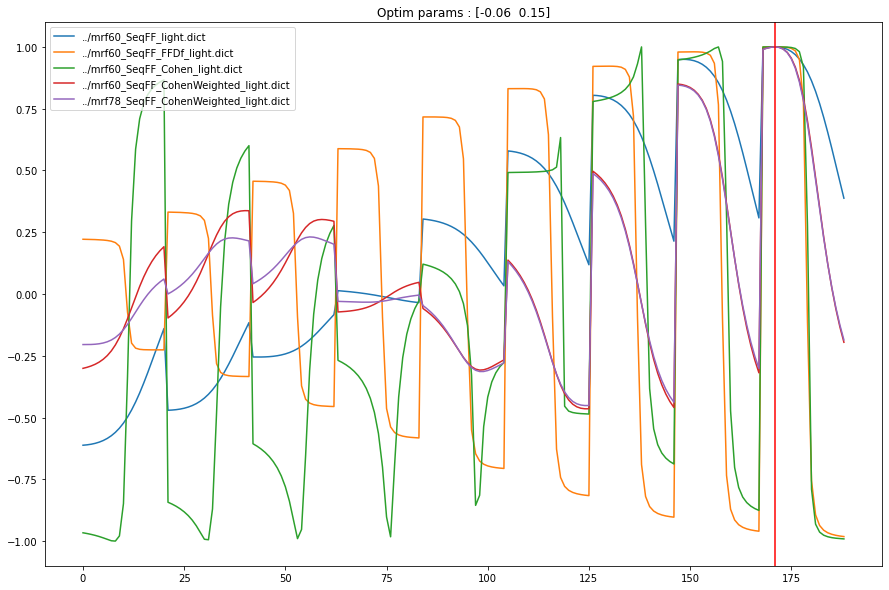

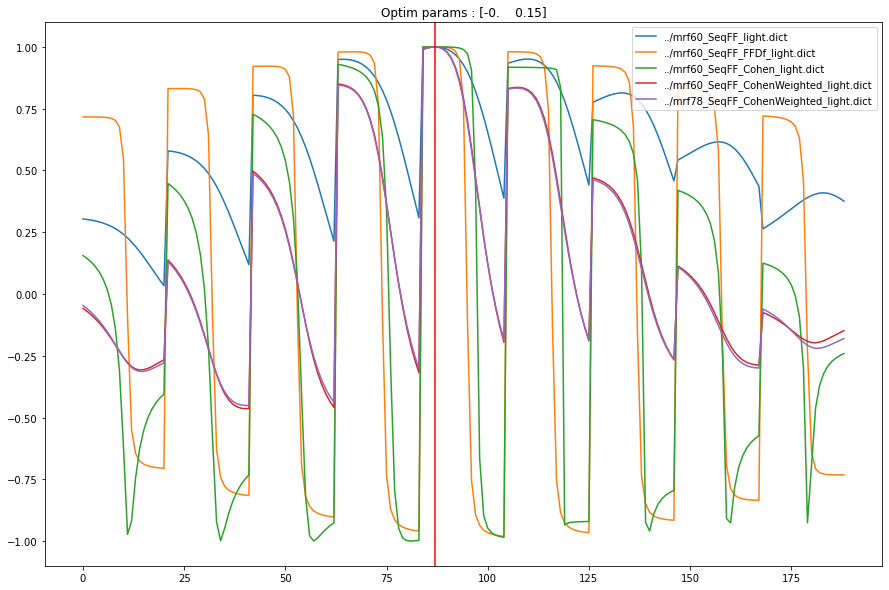

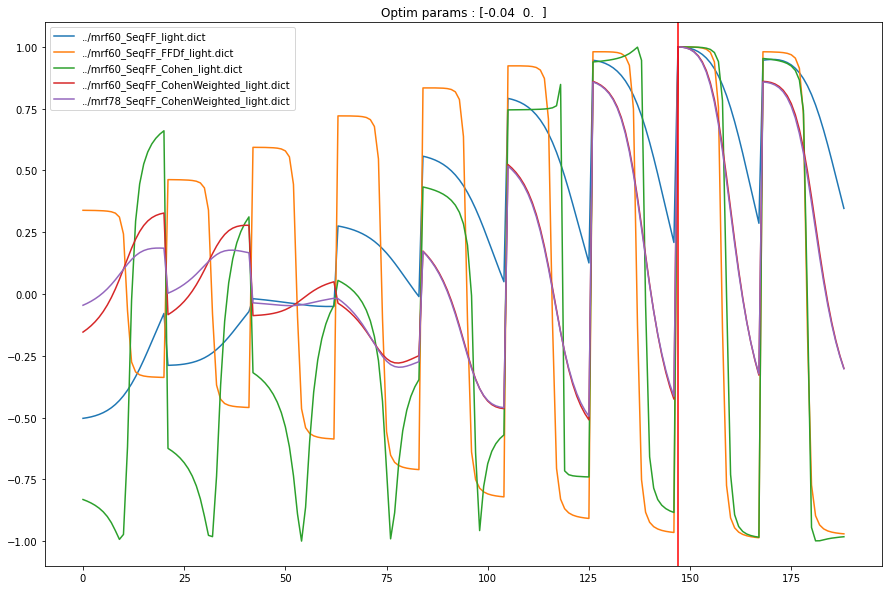

In [79]:
compare_random_signals_correlations(dictfile_corr_mapping,axis_values,num_sig=5)

In [73]:
dictfile_value_mapping.keys()

dict_keys(['../mrf60_SeqFF_light.dict', '../mrf60_SeqFF_FFDf_light.dict', '../mrf60_SeqFF_Cohen_light.dict', '../mrf60_SeqFF_CohenWeighted_light.dict'])

In [74]:
dictfile_value_mapping["../mrf60_SeqFF_CohenWeighted_light.dict"].shape

(18144, 60)

/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


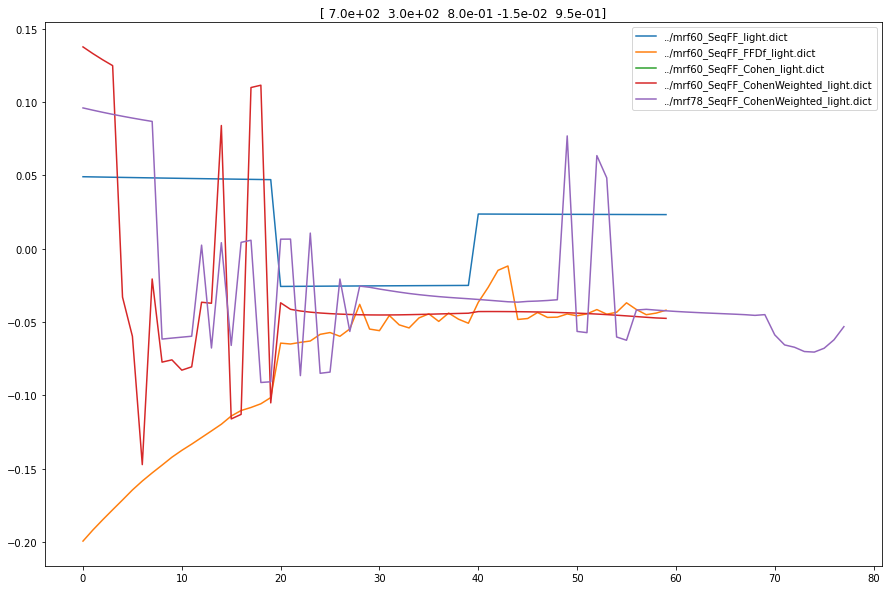

In [80]:

random_idx=np.random.choice(dictfile_value_mapping['../mrf60_SeqFF_light.dict'].shape[0])
metric=np.real

plt.figure(figsize=(15,10))
for k in dictfile_value_mapping.keys():    
    plt.plot(metric(dictfile_value_mapping[k][random_idx]),label=k)
#plt.plot(metric(dictfile_value_mapping["../mrf60_SeqFF_CohenWeighted_light.dict"][random_idx]))
plt.title(keys[random_idx])
plt.legend()

(18144, 5)

## T1

In [71]:
fixed_parameters_list=["Df","FF","B1"]

/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


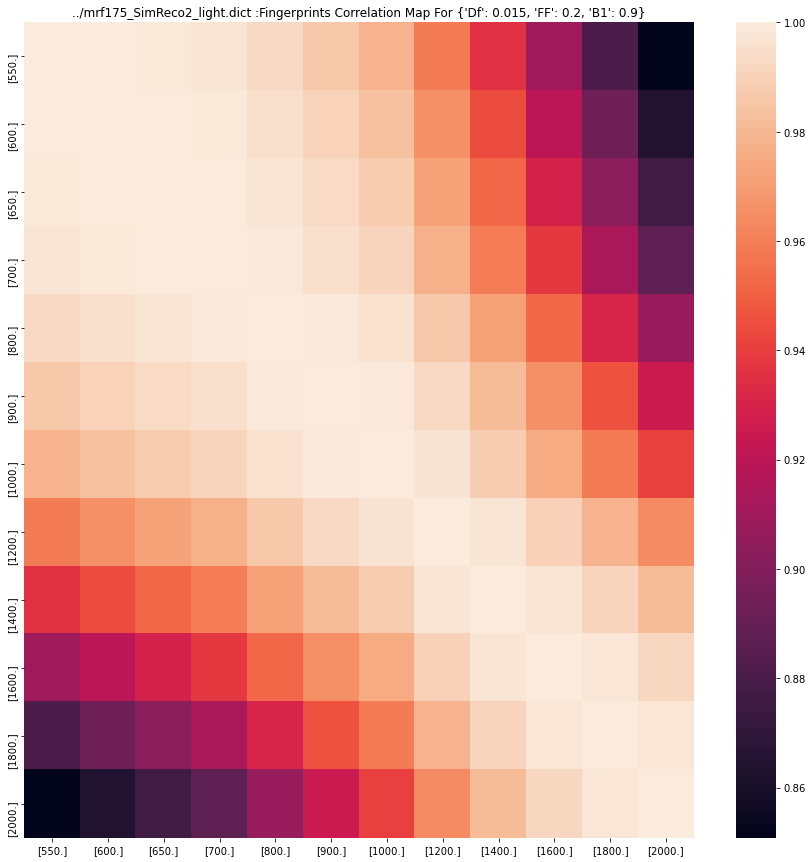

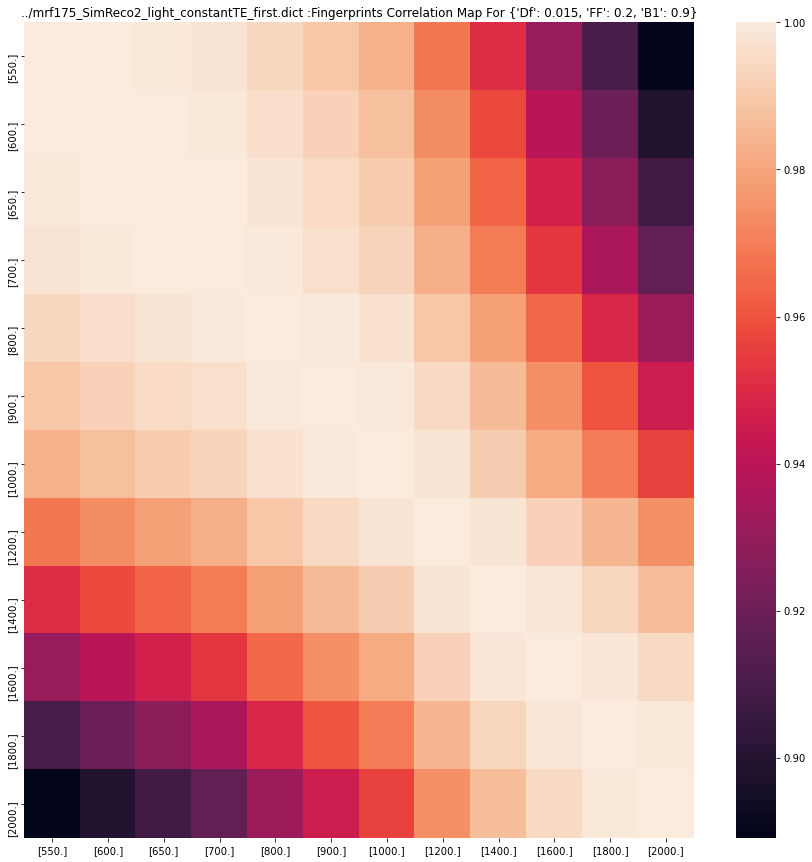

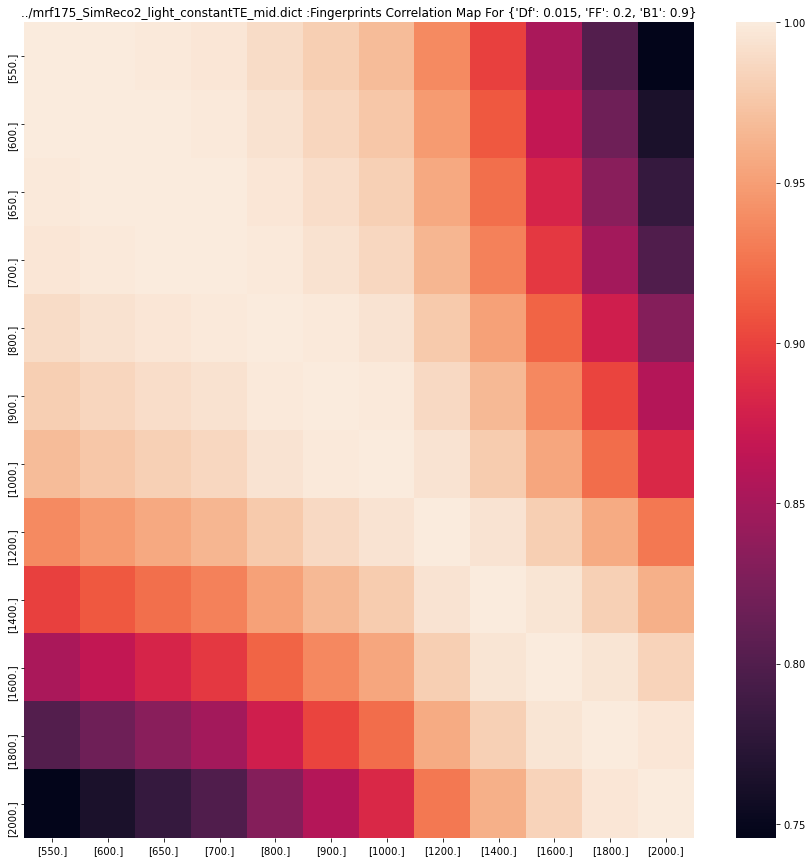

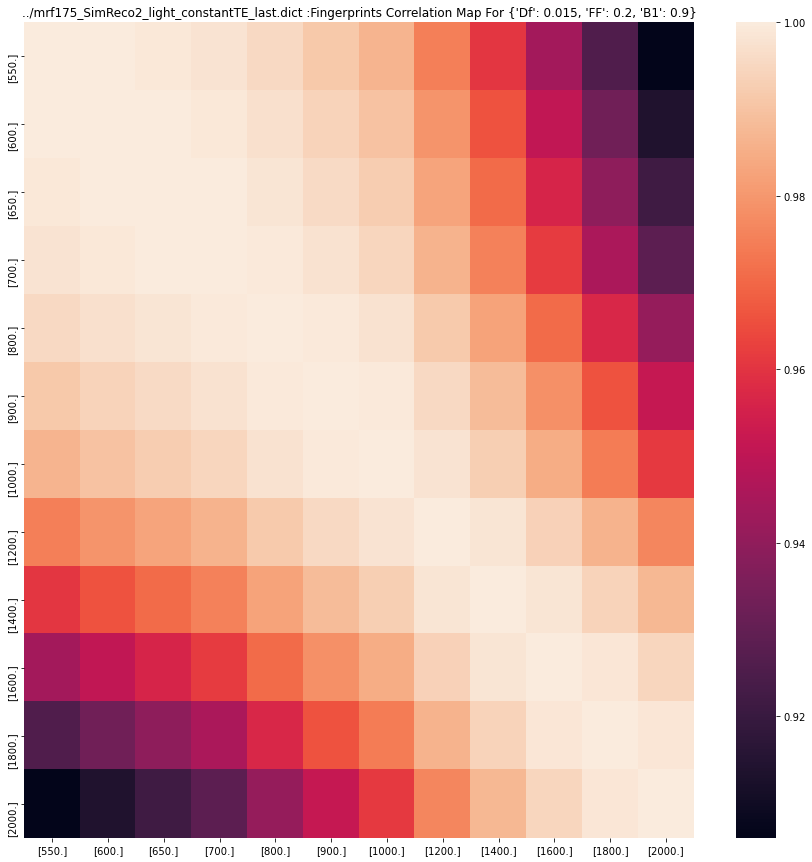

In [72]:
dictfile_corr_mapping,axis_values=compare_dict_covariance(dictfile_value_mapping,keys,fixed_parameters_list)

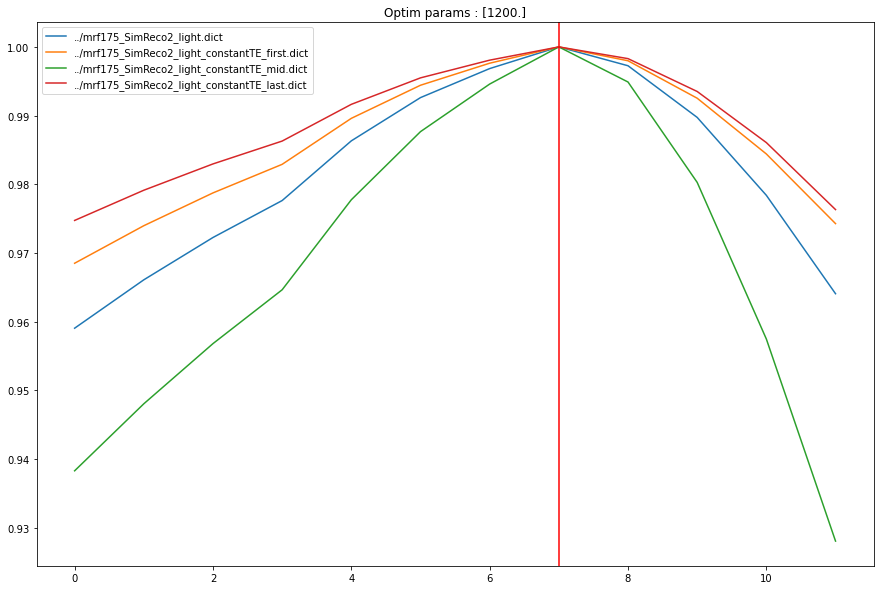

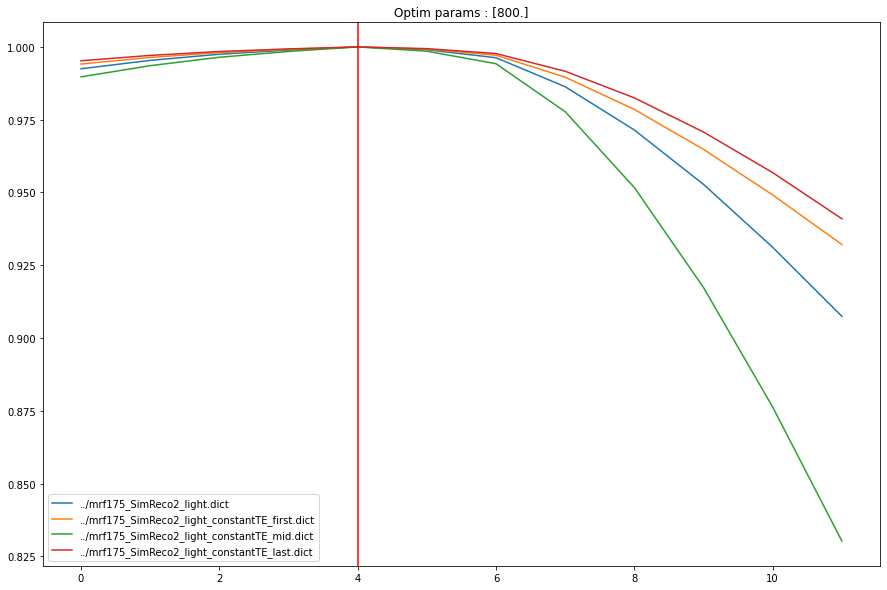

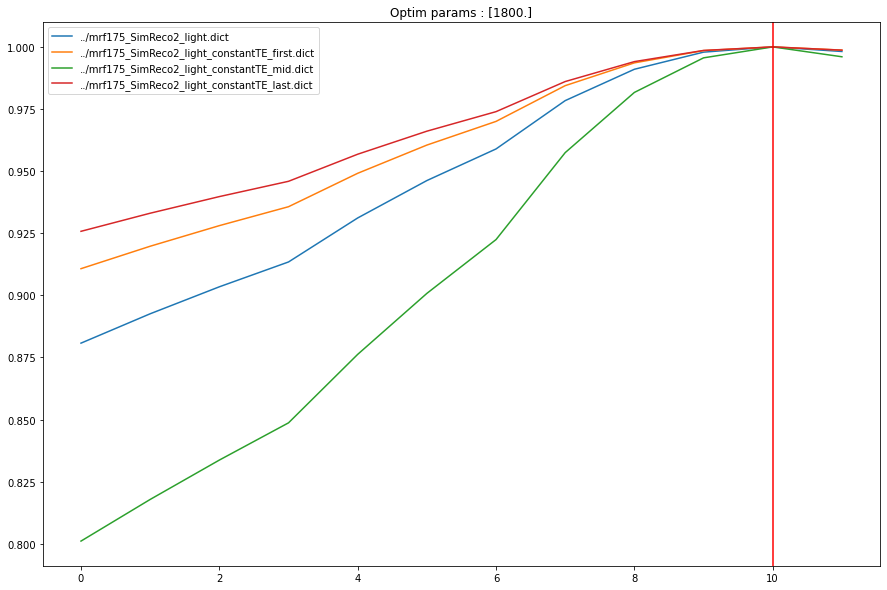

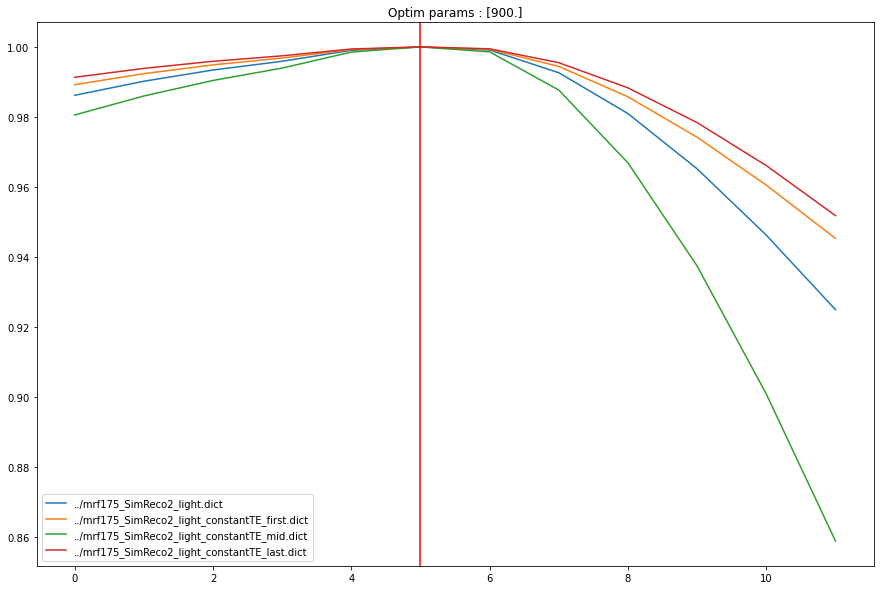

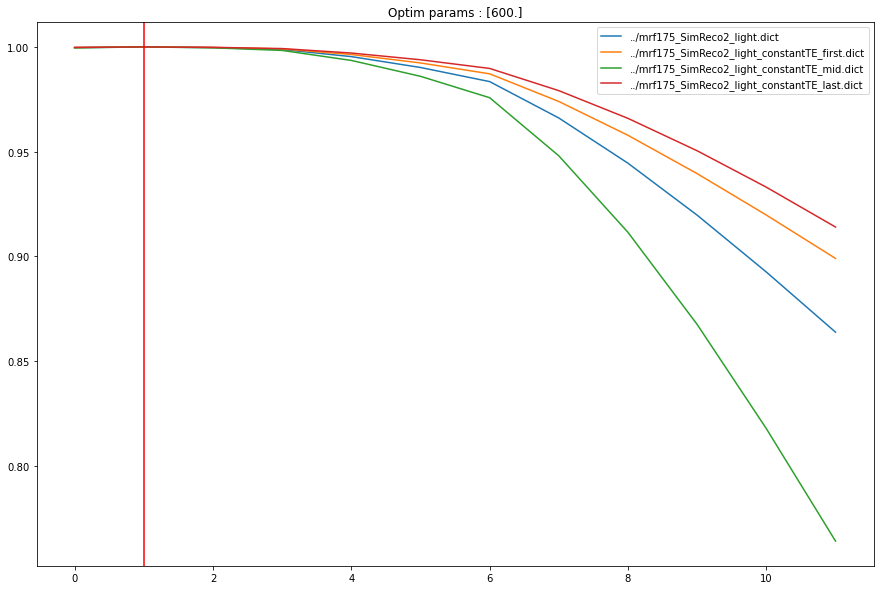

In [73]:
compare_random_signals_correlations(dictfile_corr_mapping,axis_values,num_sig=5)

# Play with first Plateau

In [83]:
dictfile_list=["../mrf175_SimReco2_light.dict","../mrf175_SimReco2_light_plateau200.dict","../mrf175_SimReco2_light_plateau400.dict","../mrf175_SimReco2_light_plateau600.dict"] 
dictfile_value_mapping,keys=fill_dictfile_value_mapping(dictfile_list)

## Df FF 

In [84]:
fixed_parameters_list=["wT1","B1"]

/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


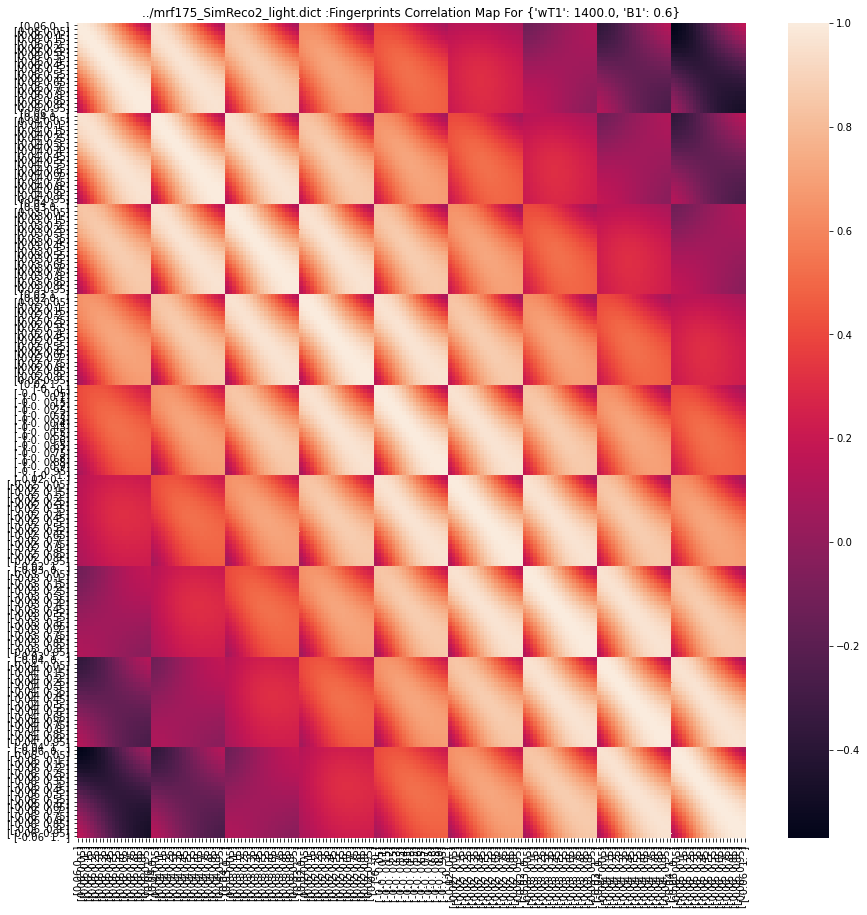

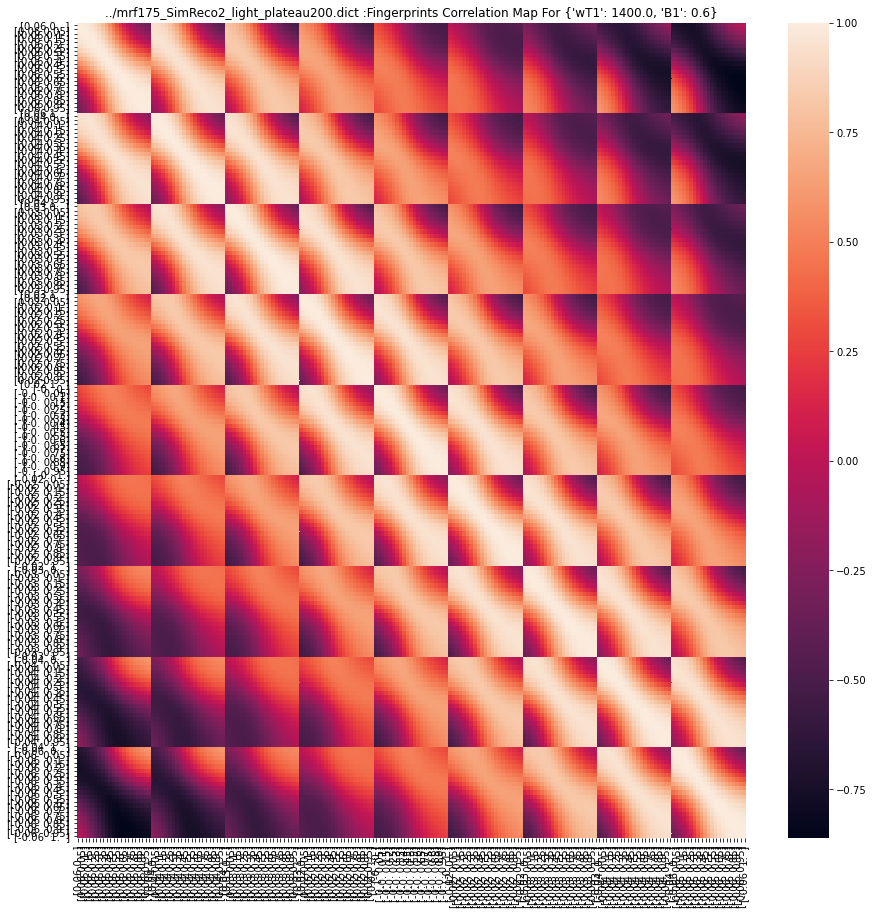

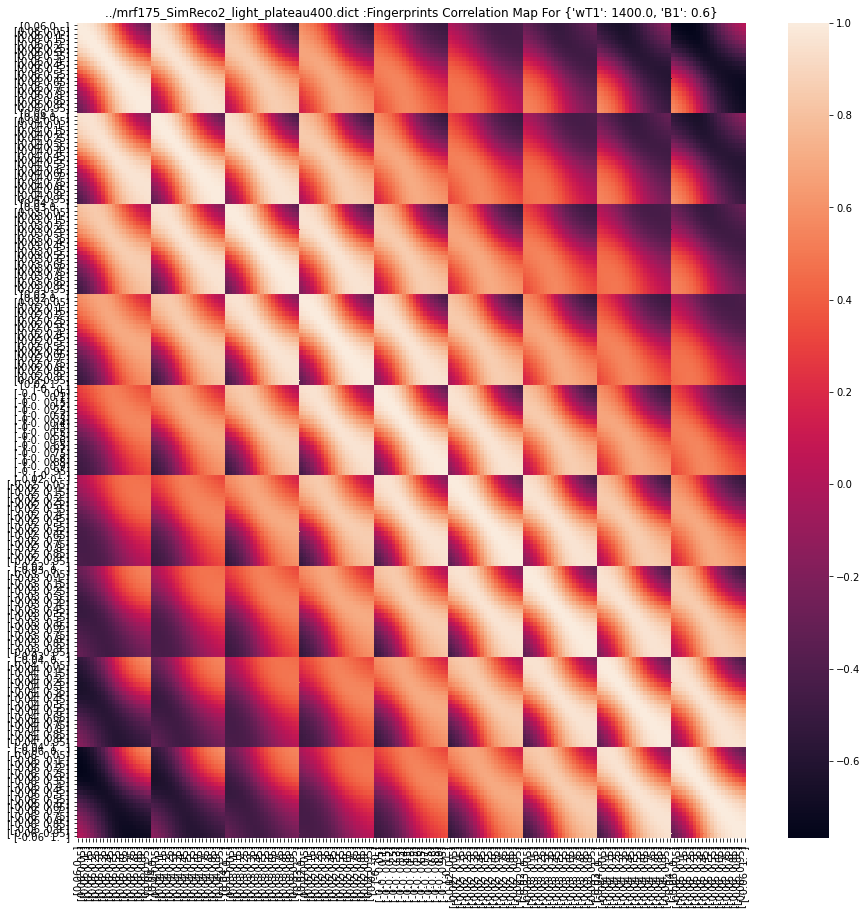

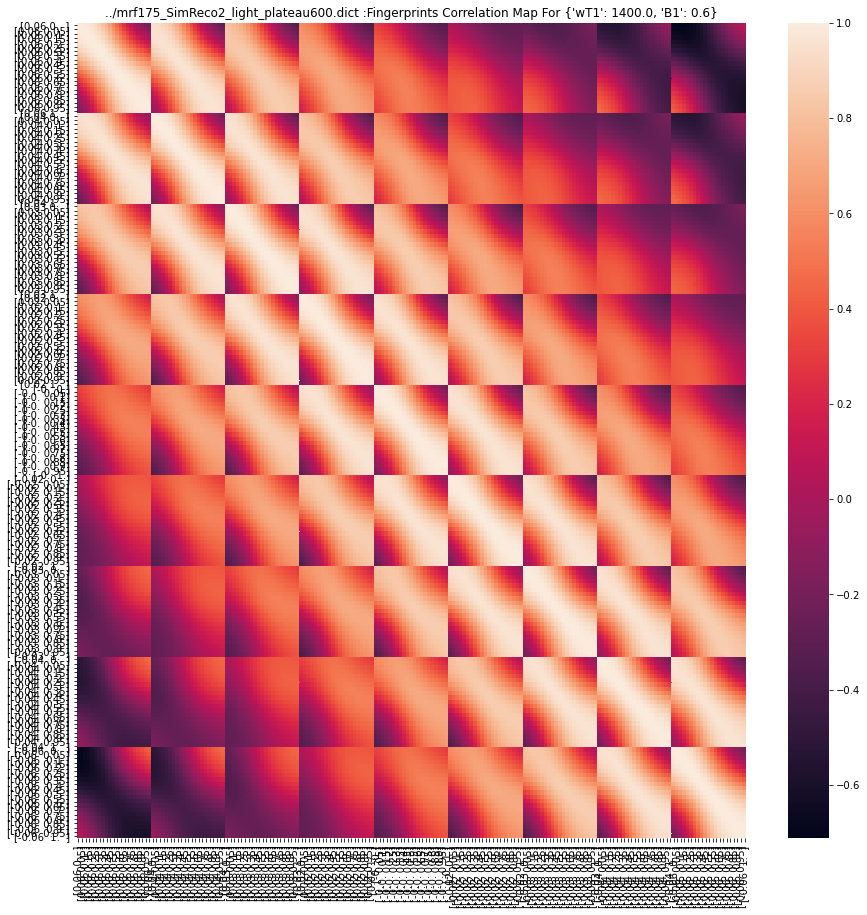

In [85]:
dictfile_corr_mapping,axis_values=compare_dict_covariance(dictfile_value_mapping,keys,fixed_parameters_list)

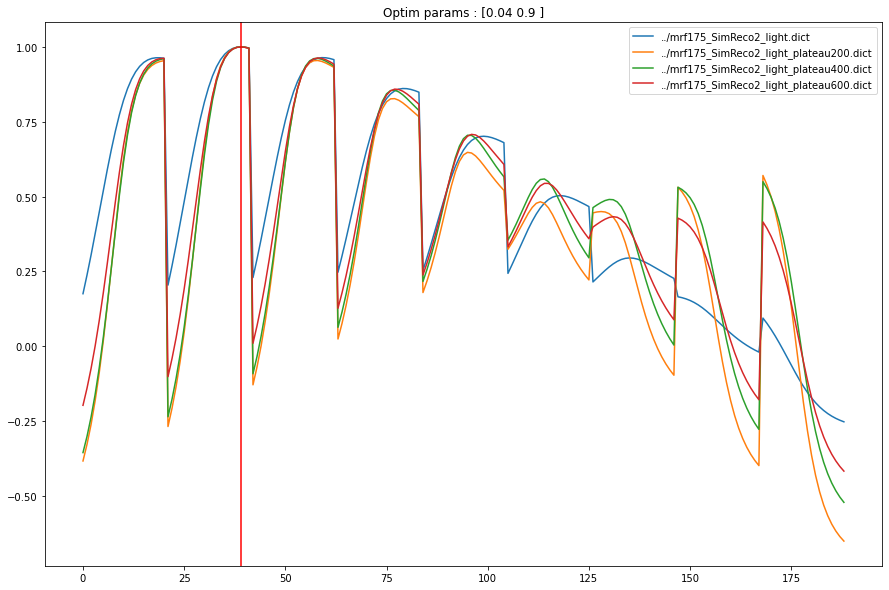

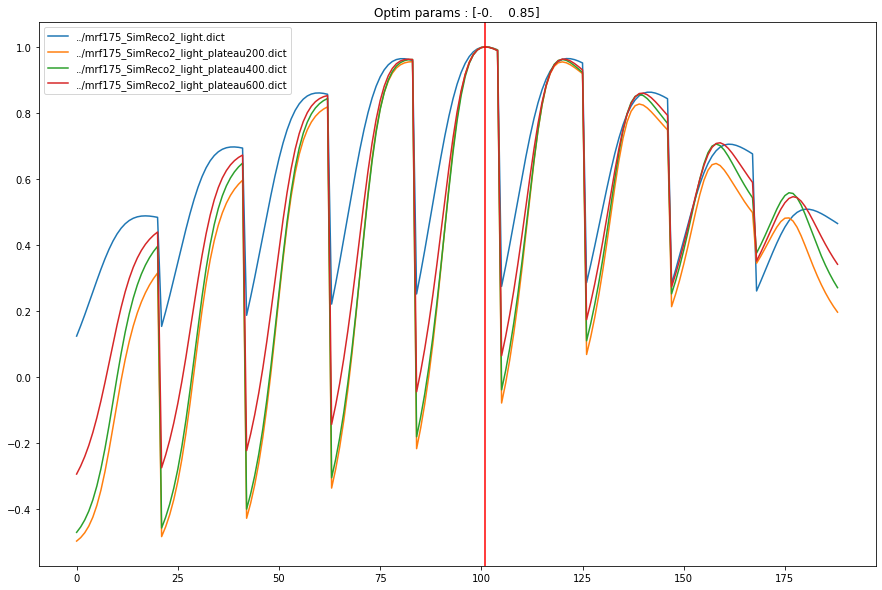

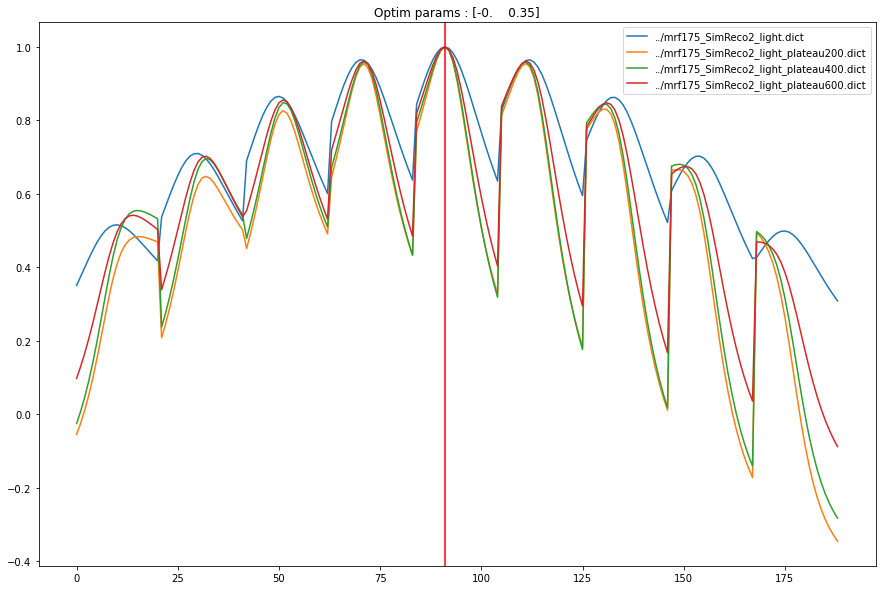

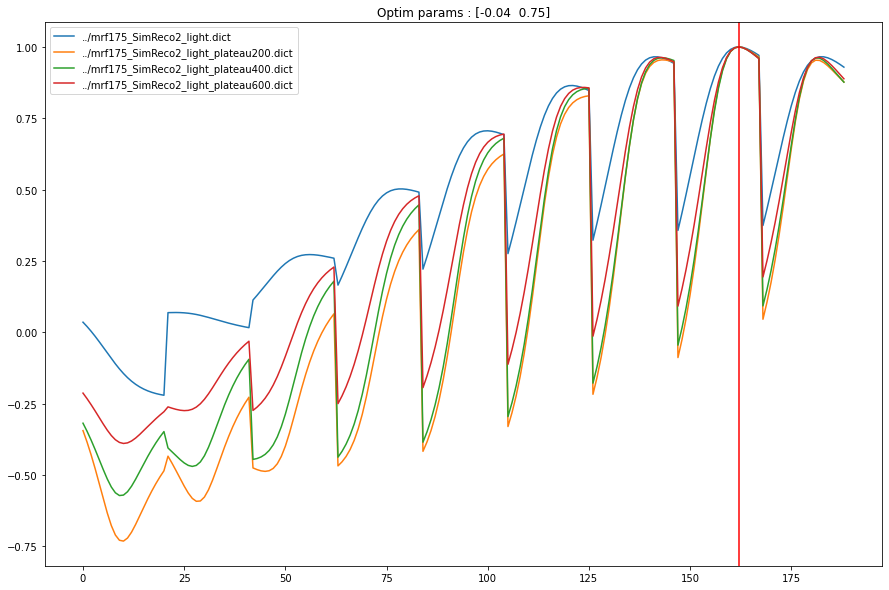

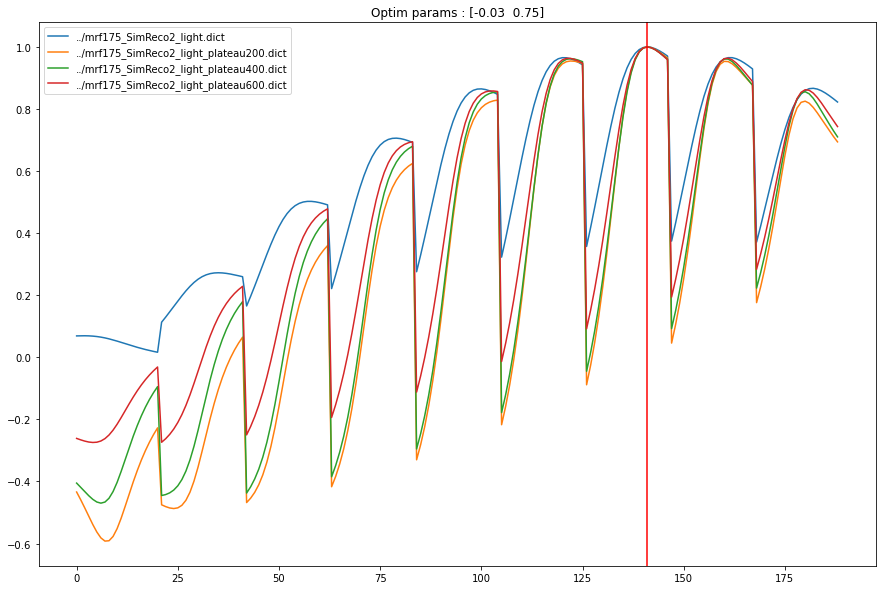

In [86]:
compare_random_signals_correlations(dictfile_corr_mapping,axis_values,num_sig=5)

## T1 

In [87]:
fixed_parameters_list=["Df","FF","B1"]

/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


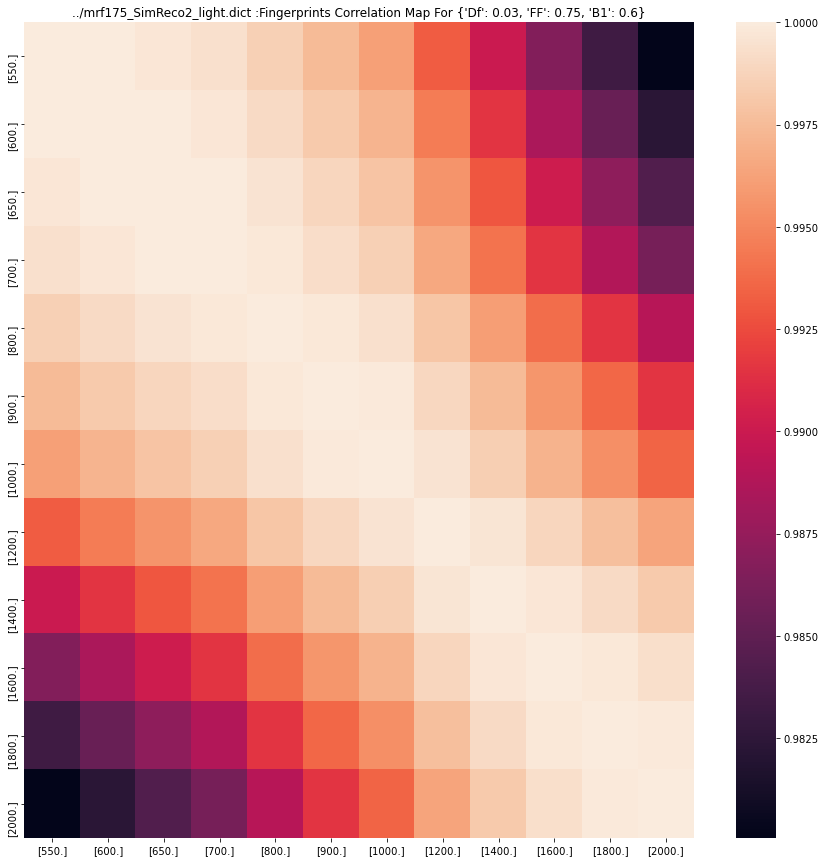

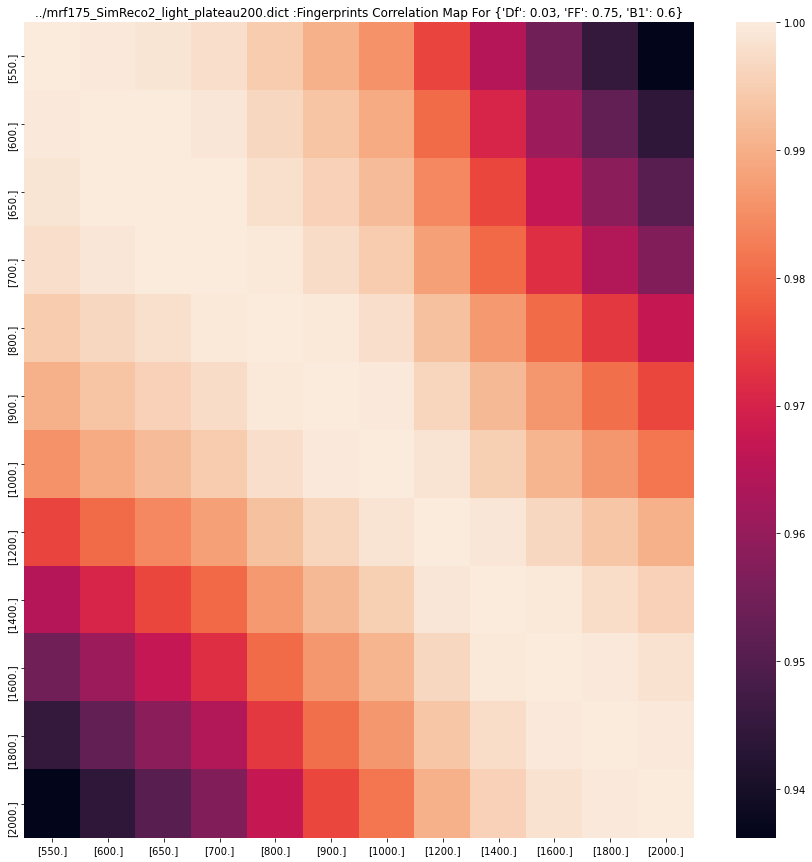

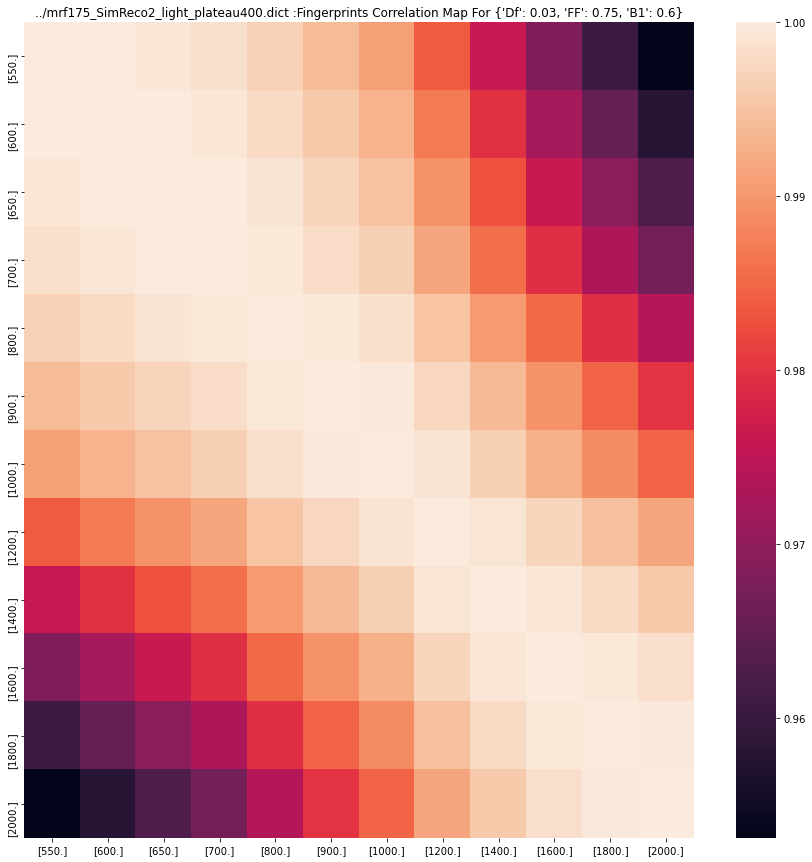

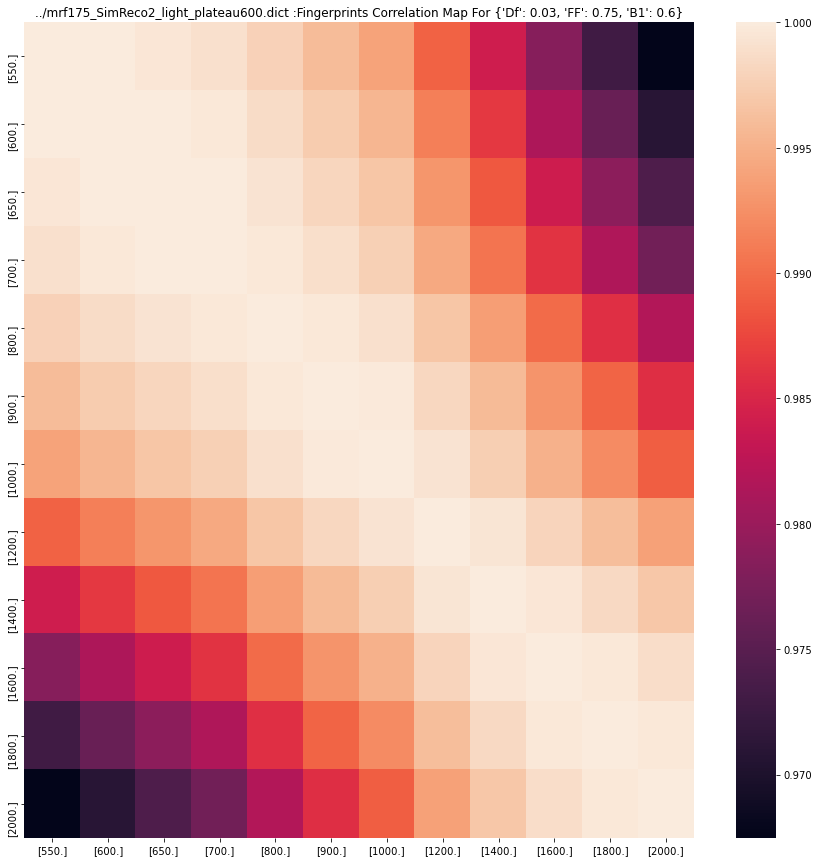

In [88]:
dictfile_corr_mapping,axis_values=compare_dict_covariance(dictfile_value_mapping,keys,fixed_parameters_list)

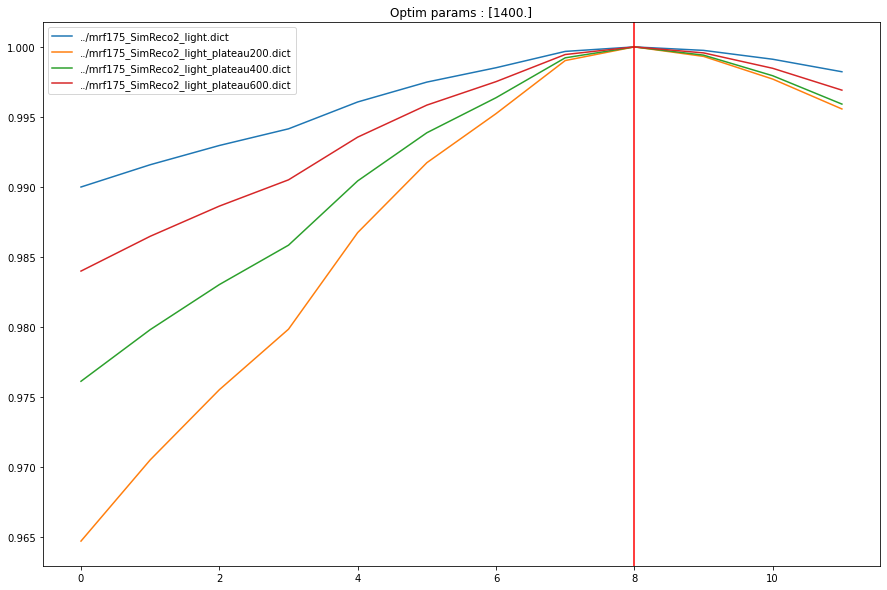

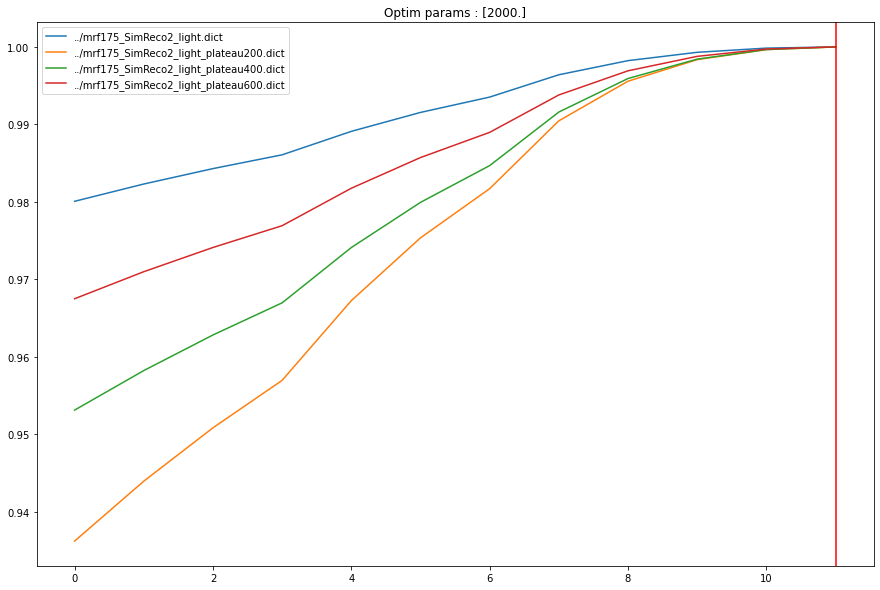

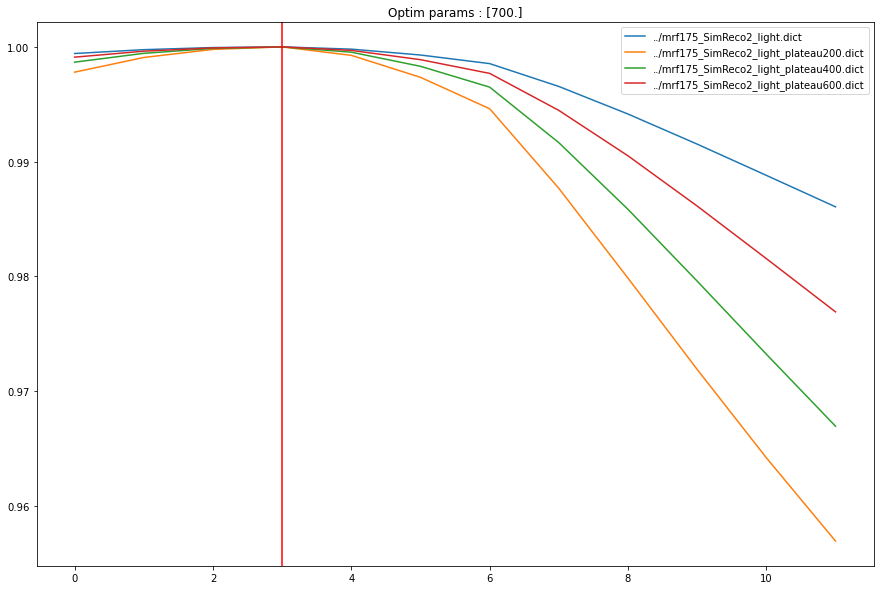

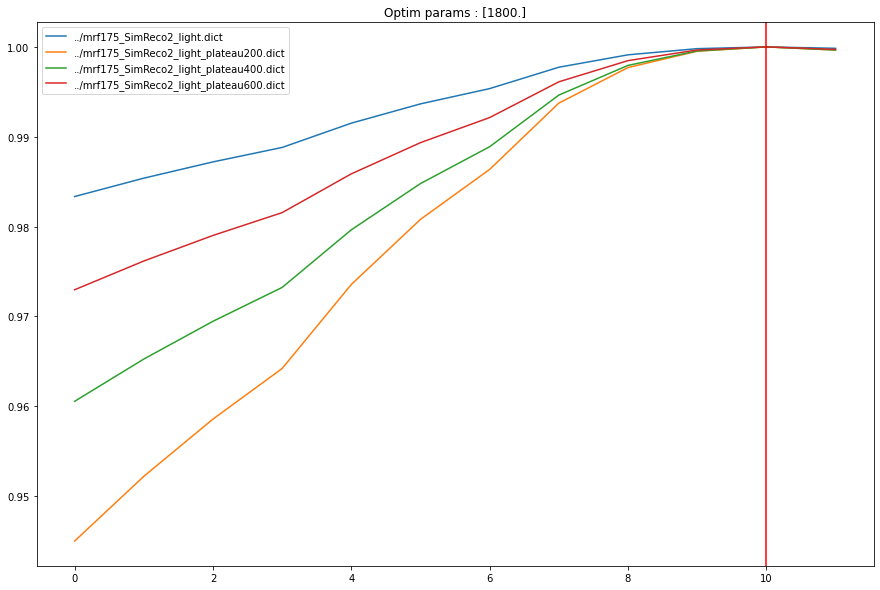

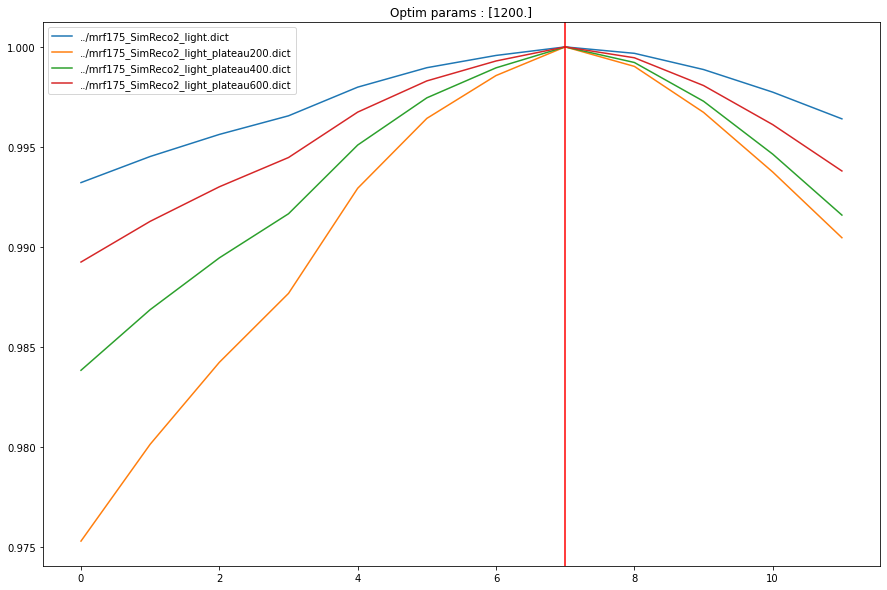

In [94]:
compare_random_signals_correlations(dictfile_corr_mapping,axis_values,num_sig=5)

In [90]:
2.39/1000*800*0.06*1000

114.72

In [92]:
2.39/1000*60*1000

143.4

In [93]:
60/(42.56*1000)

0.0014097744360902255

In [50]:
print("Optim FF {} - Optim Df {}".format(ff_optim,df_optim))
print("###########################")
correl_max_by_df = []
for df_cur in df_all:
    index_df = keys_b1_t1[:,-2:][:,0]==df_cur
    keys_df = keys_b1_t1[:,-2:][index_df]
    corr_signal_cur=corr_signal[num_signal,index_df]
    ind_max=np.argmax(corr_signal_cur)
    print("Optim FF for Df {} is {} --- CORREL {}".format(df_cur,np.round(keys_df[ind_max,1],2),np.round(corr_signal_cur[ind_max],2)))
    correl_max_by_df.append(corr_signal_cur[ind_max])
    

Optim FF 0.7 - Optim Df 0.06
###########################
Optim FF for Df -0.06 is 0.0 --- CORREL -0.1
Optim FF for Df -0.045 is 0.0 --- CORREL 0.05
Optim FF for Df -0.03 is 0.0 --- CORREL 0.19
Optim FF for Df -0.015 is 0.35 --- CORREL 0.35
Optim FF for Df -0.0 is 0.5 --- CORREL 0.54
Optim FF for Df 0.015 is 0.55 --- CORREL 0.73
Optim FF for Df 0.03 is 0.6 --- CORREL 0.87
Optim FF for Df 0.045 is 0.65 --- CORREL 0.97
Optim FF for Df 0.06 is 0.7 --- CORREL 1.0


In [51]:
print("CONSTANTT_TE_mid")
print("Optim FF {} - Optim Df {}".format(ff_optim,df_optim))
print("###########################")
correl_max_by_df_constantTE_mid = []
for df_cur in df_all:
    index_df = keys_b1_t1[:,-2:][:,0]==df_cur
    keys_df = keys_b1_t1[:,-2:][index_df]
    corr_signal_cur=corr_signal_constantTE_mid[num_signal,index_df]
    ind_max=np.argmax(corr_signal_cur)
    print("Optim FF for Df {} is {} --- CORREL {}".format(df_cur,np.round(keys_df[ind_max,1],2),np.round(corr_signal_cur[ind_max],2)))
    correl_max_by_df_constantTE_mid.append(corr_signal_cur[ind_max])
    

CONSTANTT_TE_mid
Optim FF 0.7 - Optim Df 0.06
###########################
Optim FF for Df -0.06 is 0.0 --- CORREL 0.5
Optim FF for Df -0.045 is 0.0 --- CORREL 0.73
Optim FF for Df -0.03 is 0.0 --- CORREL 0.88
Optim FF for Df -0.015 is 0.0 --- CORREL 0.94
Optim FF for Df -0.0 is 0.3 --- CORREL 0.95
Optim FF for Df 0.015 is 0.45 --- CORREL 0.96
Optim FF for Df 0.03 is 0.55 --- CORREL 0.98
Optim FF for Df 0.045 is 0.6 --- CORREL 0.99
Optim FF for Df 0.06 is 0.7 --- CORREL 1.0


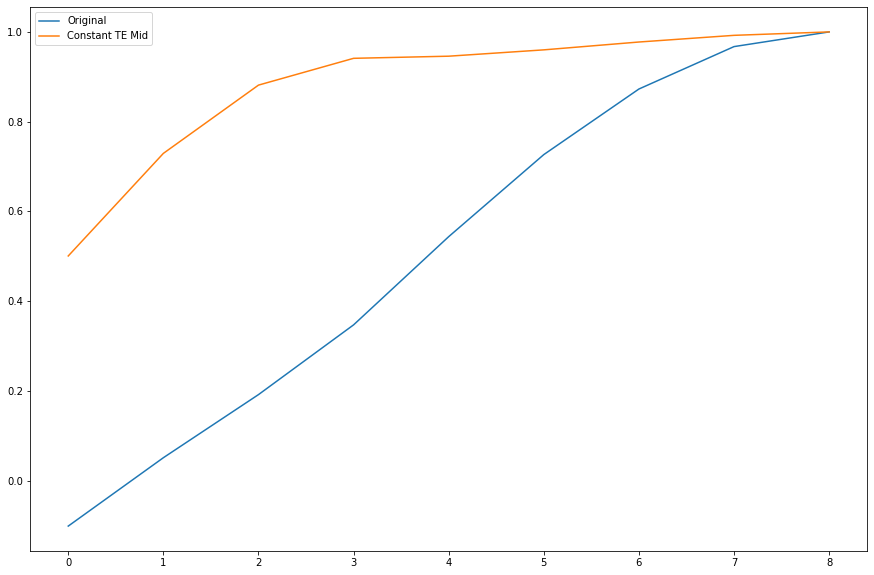

In [53]:
plt.figure(figsize=(15,10))
plt.plot(correl_max_by_df,label="Original")
plt.plot(correl_max_by_df_constantTE_mid,label="Constant TE Mid")
plt.legend()


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 20.61it/s]


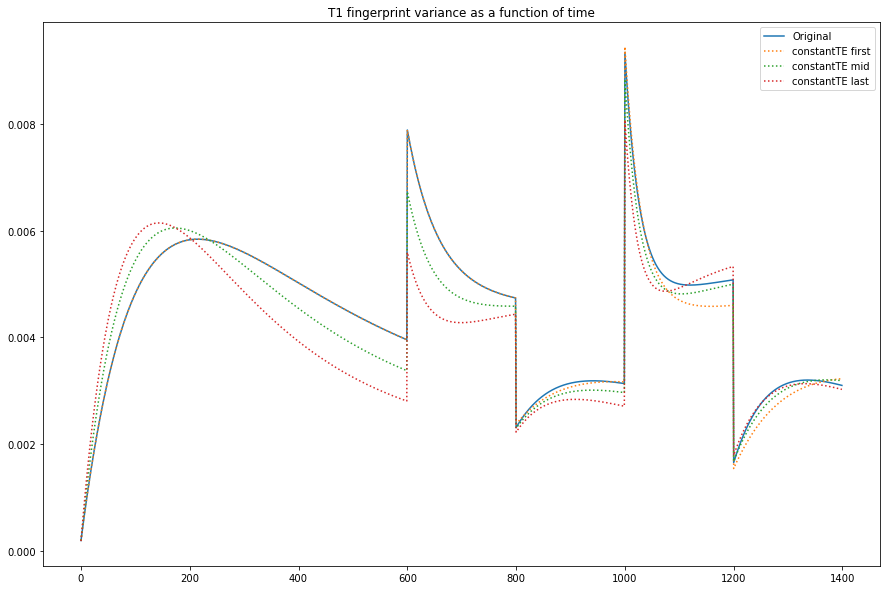

In [81]:
mean_variance_t1 = calculate_variance(2,3,4,keys_unique,values_unique)
mean_variance_t1_constantTE_first = calculate_variance(2,3,4,keys_unique,values_unique_constantTE_first)
mean_variance_t1_constantTE_mid = calculate_variance(2,3,4,keys_unique,values_unique_constantTE_mid)
mean_variance_t1_constantTE_last = calculate_variance(2,3,4,keys_unique,values_unique_constantTE_last)

plt.figure(figsize=(15,10))
plt.plot(mean_variance_t1,label="Original")
plt.plot(mean_variance_t1_constantTE_first,label="constantTE first",linestyle="dotted")
plt.plot(mean_variance_t1_constantTE_mid,label="constantTE mid",linestyle="dotted")
plt.plot(mean_variance_t1_constantTE_last,label="constantTE last",linestyle="dotted")
plt.title("T1 fingerprint variance as a function of time")
plt.legend()

### FF

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 30.75it/s]


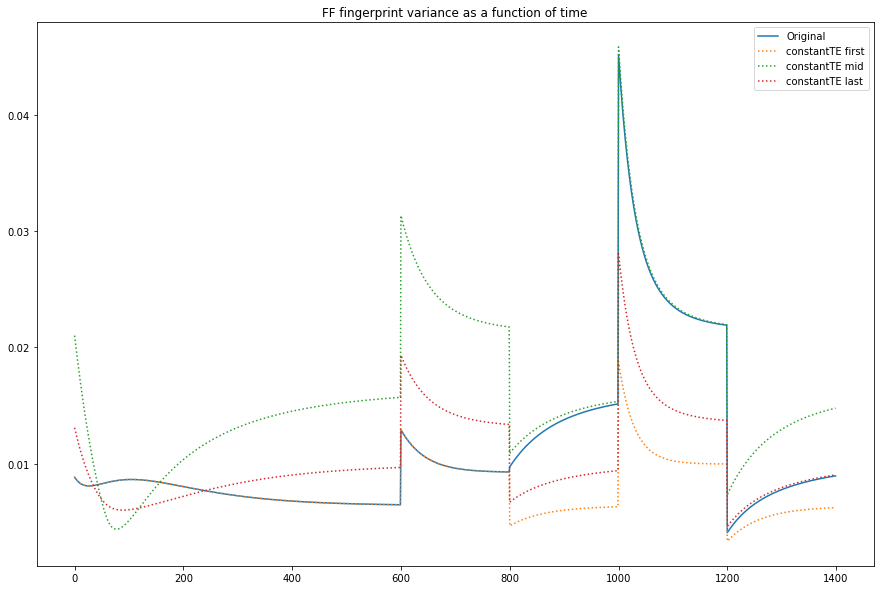

In [82]:
mean_variance_ff = calculate_variance(2,3,0,keys_unique,values_unique)
mean_variance_ff_constantTE_first = calculate_variance(2,3,0,keys_unique,values_unique_constantTE_first)
mean_variance_ff_constantTE_mid = calculate_variance(2,3,0,keys_unique,values_unique_constantTE_mid)
mean_variance_ff_constantTE_last = calculate_variance(2,3,0,keys_unique,values_unique_constantTE_last)


plt.figure(figsize=(15,10))
plt.plot(mean_variance_ff,label="Original")
plt.plot(mean_variance_ff_constantTE_first,label="constantTE first",linestyle="dotted")
plt.plot(mean_variance_ff_constantTE_mid,label="constantTE mid",linestyle="dotted")
plt.plot(mean_variance_ff_constantTE_last,label="constantTE last",linestyle="dotted")
plt.title("FF fingerprint variance as a function of time")
plt.legend()

## B1

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 28.95it/s]


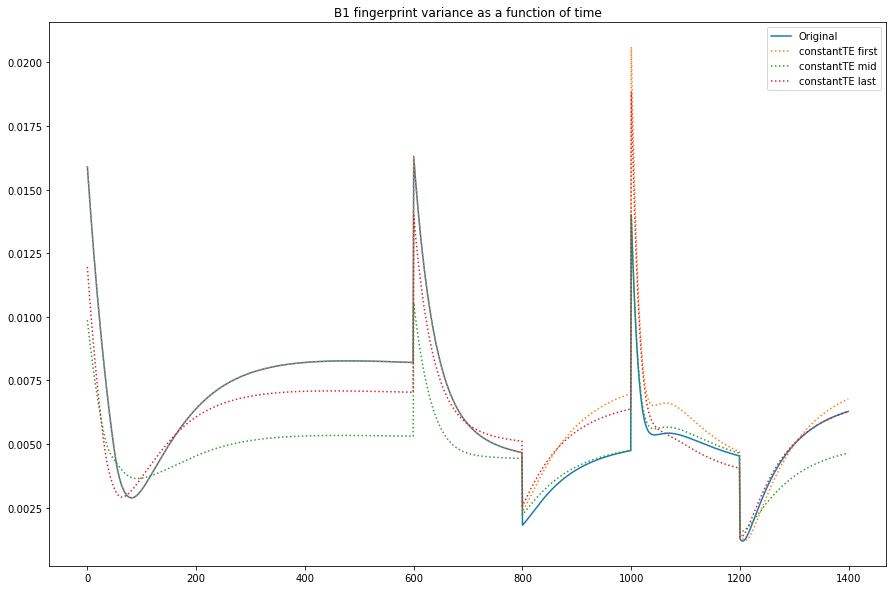

In [83]:
mean_variance_b1 = calculate_variance(0,3,4,keys_unique,values_unique)
mean_variance_b1_constantTE_first = calculate_variance(0,3,4,keys_unique,values_unique_constantTE_first)
mean_variance_b1_constantTE_mid = calculate_variance(0,3,4,keys_unique,values_unique_constantTE_mid)
mean_variance_b1_constantTE_last = calculate_variance(0,3,4,keys_unique,values_unique_constantTE_last)


plt.figure(figsize=(15,10))
plt.plot(mean_variance_b1,label="Original")
plt.plot(mean_variance_b1_constantTE_first,label="constantTE first",linestyle="dotted")
plt.plot(mean_variance_b1_constantTE_mid,label="constantTE mid",linestyle="dotted")
plt.plot(mean_variance_b1_constantTE_last,label="constantTE last",linestyle="dotted")
plt.title("B1 fingerprint variance as a function of time")
plt.legend()

## DF

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 30.21it/s]


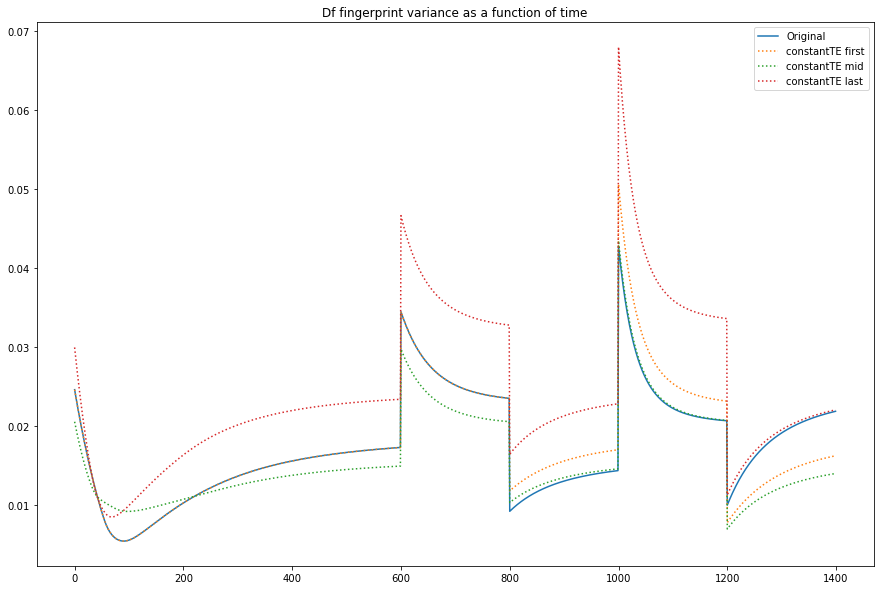

In [84]:
mean_variance_df = calculate_variance(0,2,4,keys_unique,values_unique)
mean_variance_df_constantTE_first = calculate_variance(0,2,4,keys_unique,values_unique_constantTE_first)
mean_variance_df_constantTE_mid = calculate_variance(0,2,4,keys_unique,values_unique_constantTE_mid)
mean_variance_df_constantTE_last = calculate_variance(0,2,4,keys_unique,values_unique_constantTE_last)


plt.figure(figsize=(15,10))
plt.plot(mean_variance_df,label="Original")
plt.plot(mean_variance_df_constantTE_first,label="constantTE first",linestyle="dotted")
plt.plot(mean_variance_df_constantTE_mid,label="constantTE mid",linestyle="dotted")
plt.plot(mean_variance_df_constantTE_last,label="constantTE last",linestyle="dotted")
plt.title("Df fingerprint variance as a function of time")
plt.legend()

In [154]:
t1_all

array([ 550.,  600.,  650.,  700.,  800.,  900., 1000., 1200., 1400.,
       1600., 1800., 2000.])

In [155]:
t1 = np.random.choice(t1_all)
ff = np.random.choice(ff_all)
b1 = np.random.choice(b1_all)

In [ ]:
index_keys = np.argwhere((keys_unique[:,0]==t1)&(keys_unique[:,2]==b1)&(keys_unique[:,4]==ff)).flatten()


In [176]:
df_values = keys_unique[index_keys,3]
index_sorted=np.argsort(df_values)
index_keys=index_keys[index_sorted]

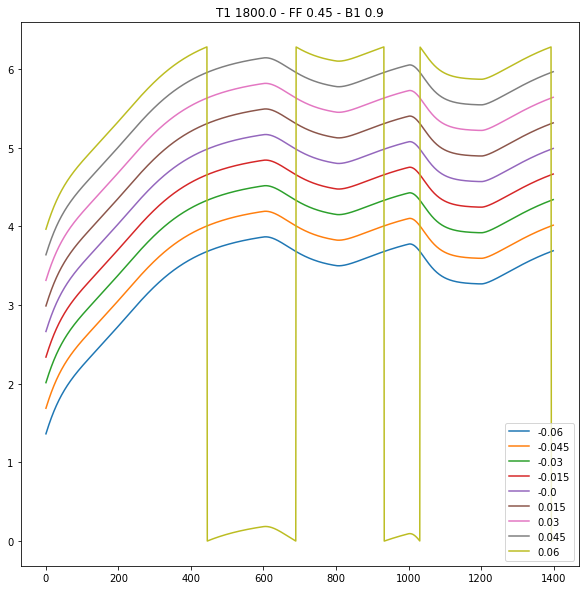

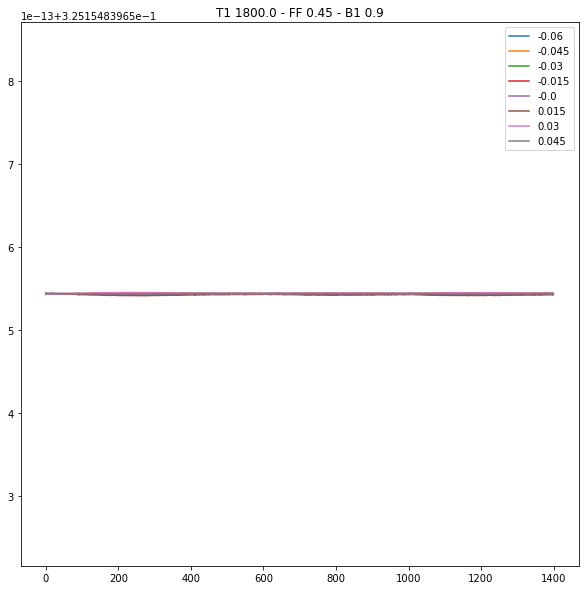

In [180]:
signals_df = values_unique_constantTE_mid[index_keys]

metric=np.angle
plt.figure(figsize=(10,10))
plot = plt.plot(np.mod(metric(signals_df.T),2*np.pi))
plt.title("T1 {} - FF {} - B1 {}".format(t1,ff,b1))
plt.legend(plot, keys_unique[index_keys,3])
metric=np.angle
plt.figure(figsize=(10,10))
plot = plt.plot(np.mod(np.diff(metric(signals_df.T)),2*np.pi))
plt.title("T1 {} - FF {} - B1 {}".format(t1,ff,b1))
plt.legend(plot, keys_unique[index_keys,3])

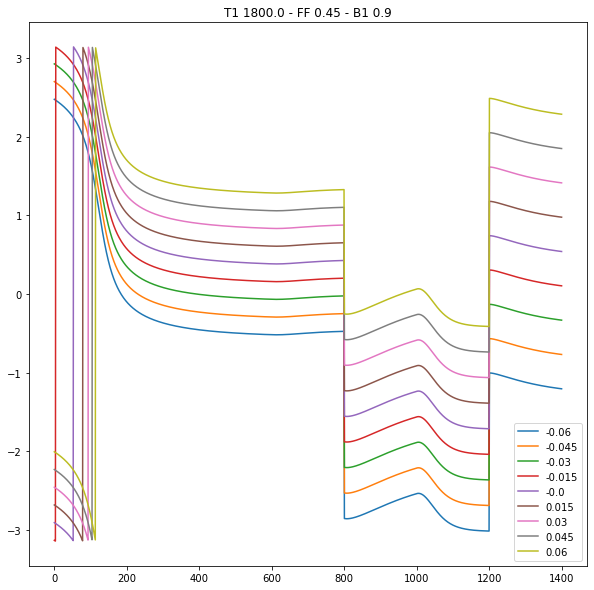

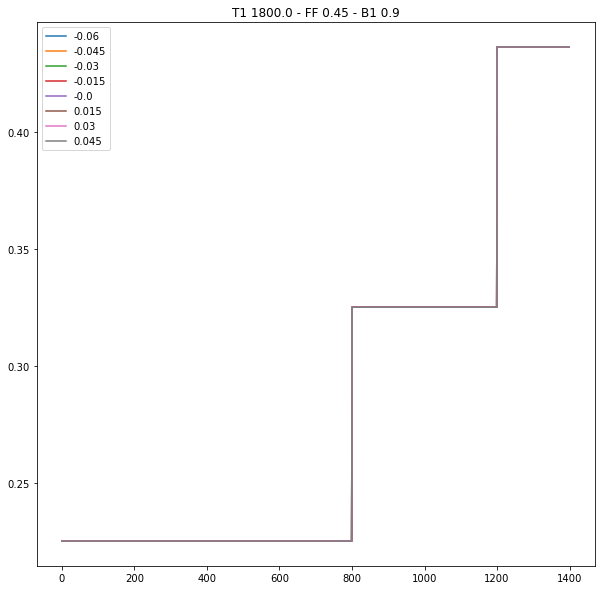

In [181]:
signals_df = values_unique[index_keys]

metric=np.angle
plt.figure(figsize=(10,10))
plot = plt.plot(metric(signals_df.T))
plt.title("T1 {} - FF {} - B1 {}".format(t1,ff,b1))
plt.legend(plot, keys_unique[index_keys,3])
metric=np.angle
plt.figure(figsize=(10,10))
plot = plt.plot(np.mod(np.diff(metric(signals_df.T)),np.pi))
plt.title("T1 {} - FF {} - B1 {}".format(t1,ff,b1))
plt.legend(plot, keys_unique[index_keys,3])